# Load model

In [1]:
import torch
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from ENet.DenseCRF import dense_crf_from_probabilities
import cv2
import pickle
# Import your custom modules (make sure these are accessible in your notebook)
from ENet.ENet import ENet
from ENet.dataset import SliceDataset
from ENet.utils import dice_coef, probs2one_hot, probs2class, class2one_hot
import seaborn as sns
import pandas as pd
from collections import defaultdict

In [12]:

# Load the metrics
metrics_focal = pickle.load(open("3D_focal_loss_10-23(15.08)/metrics3D.pkl", "rb"))
metrics_tversky = pickle.load(open("3D_tversky_loss_10-23(14.45)/metrics3D.pkl", "rb"))
metrics_dice = pickle.load(open("3D_dice_loss_10-23(14.52)/metrics3D.pkl", "rb"))
metrics_combined = pickle.load(open("3D_combined_loss_10-23(15.02)/metrics3D.pkl", "rb"))
metrics_ce = pickle.load(open("3D_ce_loss_10-23(15.14)/metrics3D.pkl", "rb"))


metrics_noise = pickle.load(open("3D_noise_10-23(15.31)/metrics3D.pkl", "rb"))
metrics_affine = pickle.load(open("3D_affine_10-23(15.43)/metrics3D.pkl", "rb"))
metrics_elastic = pickle.load(open("3D_elastic_10-23(15.49)/metrics3D.pkl", "rb"))
metrics_combined = pickle.load(open("3D_combineddata_10-23(15.37)/metrics3D.pkl", "rb"))

In [25]:



# Combine metrics into a dictionary
metrics_dict = {
    'Focal Loss': metrics_focal,
    'Tversky Loss': metrics_tversky,
    'Dice Loss': metrics_dice,
    'Combined Loss': metrics_combined,
    'Cross Entropy Loss': metrics_ce
}

# metrics_dict = {
#     'Noise': metrics_noise,
#     'Affine': metrics_affine,
#     'Elastic': metrics_elastic,
#     'All augmentations': metrics_combined
# }

# Define class names
class_names = ['Background', 'Esophagus', 'Heart', 'Trachea', 'Aorta']

# Define custom palette
custom_palette = {
    'roze': '#eb8fd8',
    'groen': '#b9d4b4',
    'paars': '#ba94e9',
    'blue': '#4C8BE2',
    'orange': '#E27A3F',
    'grey_light': '#1F3240',
    'grey_dark': '#16242F'
}

# Define custom themes
def set_custom_dark_theme():
    sns.set_context('notebook', font_scale=1.2)
    sns.set_style({
        'axes.facecolor': custom_palette['grey_light'],
        'axes.edgecolor': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'grid.color': 'white',
        'figure.facecolor': custom_palette['grey_light'],
        'text.color': 'white'
    })
    sns.set_palette([
        custom_palette['roze'],
        custom_palette['groen'],
        custom_palette['paars'],
        custom_palette['blue'],
        custom_palette['orange']
    ])

def set_custom_light_theme():
    sns.set_context('notebook', font_scale=1.2)
    sns.set_style({
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'grid.color': custom_palette["grey_light"],
        'figure.facecolor':'white',
        'text.color': 'black'
    })
    sns.set_palette([
        custom_palette['roze'],
        custom_palette['groen'],
        custom_palette['paars'],
        custom_palette['blue'],
        custom_palette['orange']
    ])

# Define a palette for the models
model_palette = {
    'Focal Loss': custom_palette['roze'],
    'Tversky Loss': custom_palette['groen'],
    'Dice Loss': custom_palette['paars'],
    'Combined Loss': custom_palette['blue'],
    'Cross Entropy Loss': custom_palette['orange']
}
# 
# model_palette = {
#     'Noise': custom_palette['roze'],
#     'Affine': custom_palette['groen'],
#     'Elastic': custom_palette['paars'],
#     'All augmentations': custom_palette['blue']
# }

In [19]:
# Prepare data for plotting
all_data = []

for model_name, metrics in metrics_dict.items():
    for metric_name in ['3D Dice', '3D Hausdorff distance']:
        metric_values = np.array(metrics[metric_name])  # Shape: (num_samples, num_classes)
        num_samples, num_classes = metric_values.shape
        # Exclude background class (assume class 0 is background)
        for class_idx in range(1, num_classes):
            class_name = class_names[class_idx]
            values = metric_values[:, class_idx]  # Shape: (num_samples,)
            # Exclude Dice scores that are exactly 1.0
            # if metric_name == 'Dice':
            #     values = values[values != 1.0]
            #     values = values[values != 0.0]
            #     
            # if metric_name == 'Hausdorff distance':
            #     values = values[values != 1.0]
            #     values = values[values != 0.0]
                
            for value in values:
                all_data.append({
                    'Model': model_name,
                    'Class': class_name,
                    'Metric': metric_name,
                    'Value': value
                })

df = pd.DataFrame(all_data)


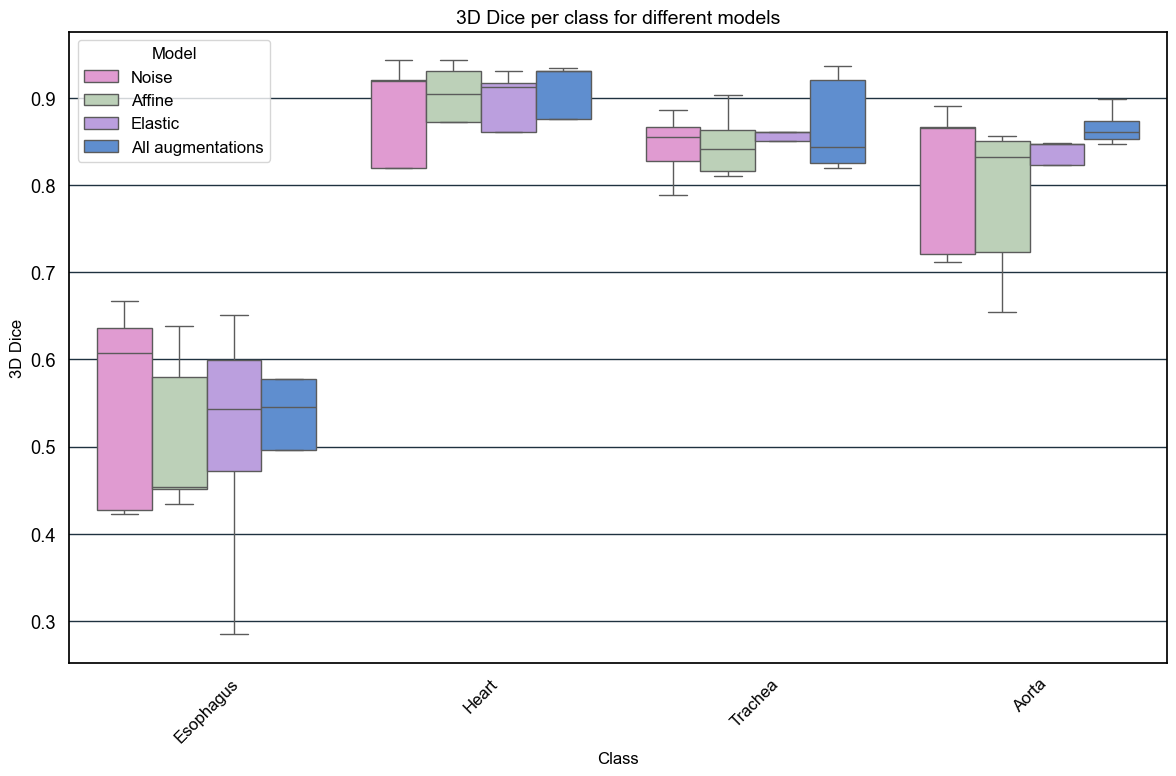

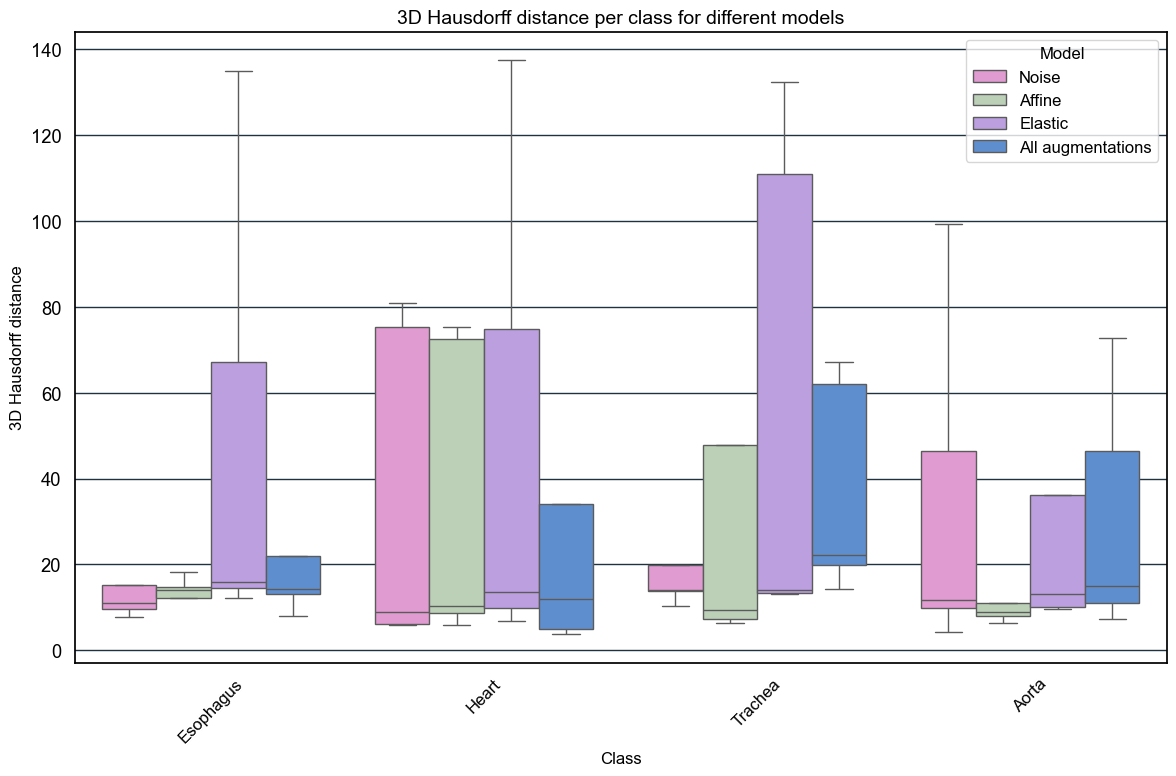

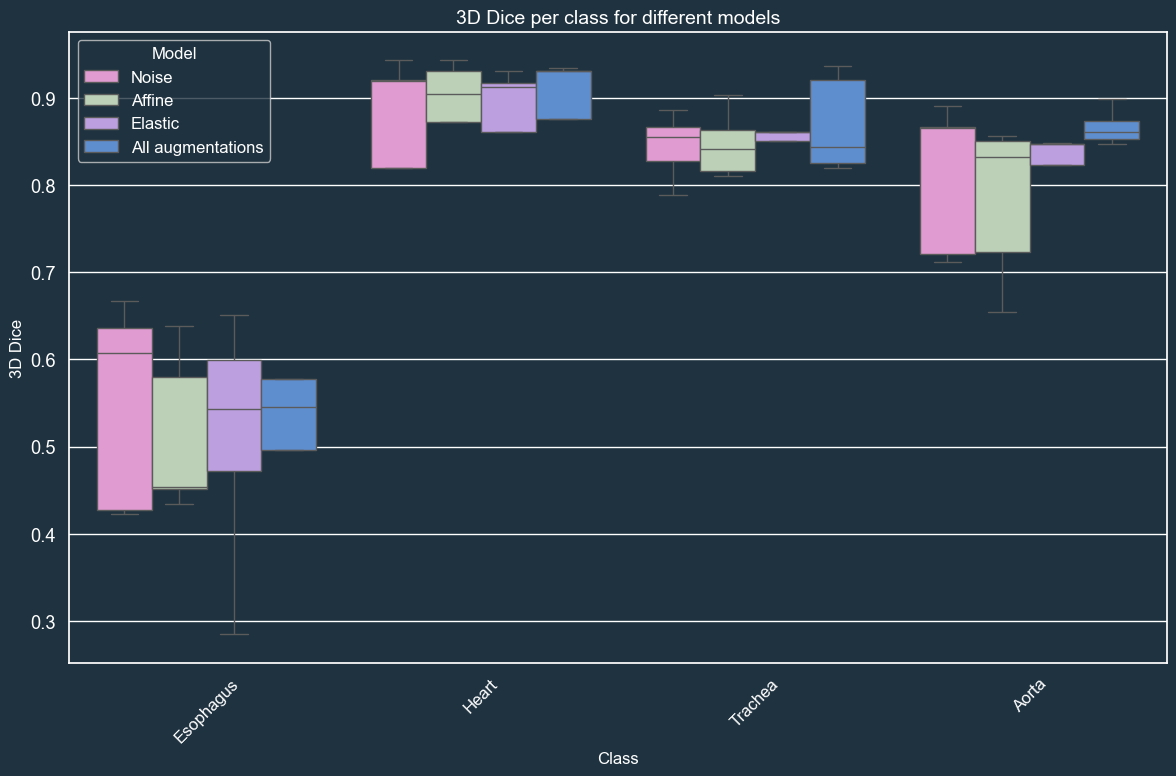

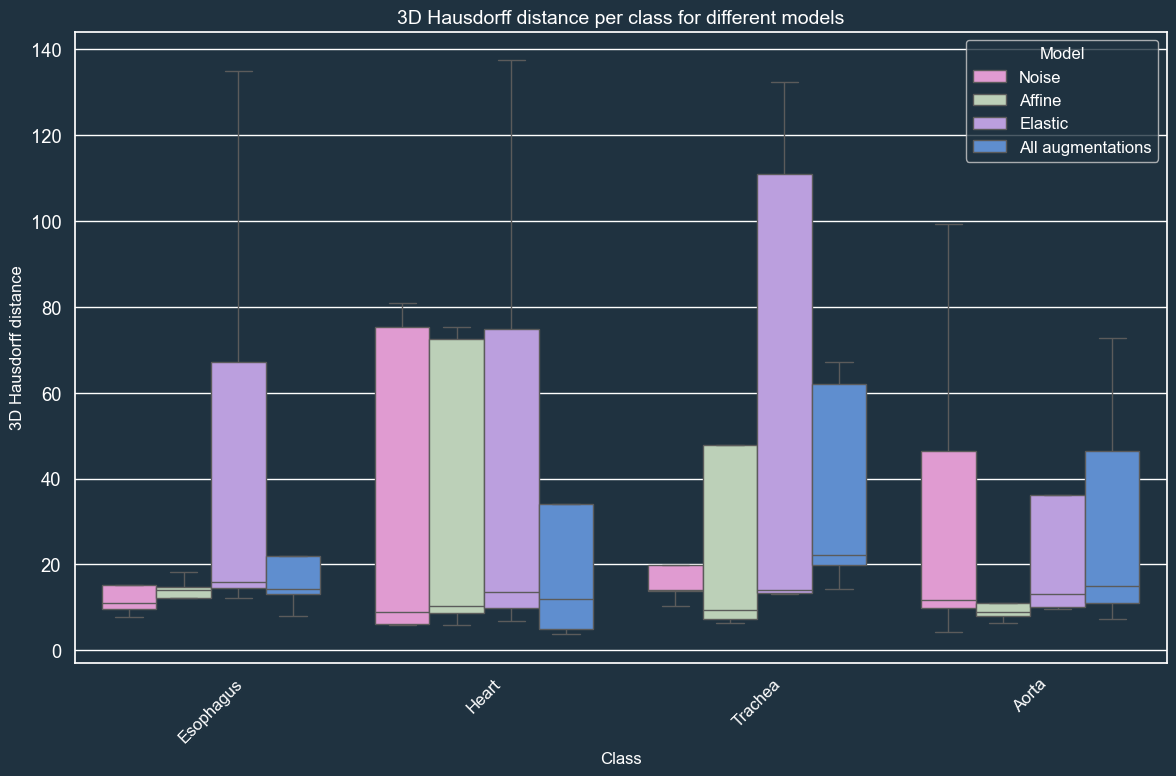

In [20]:
# Create boxplots for each metric using custom themes
for theme in ['light', 'dark']:
    if theme == 'dark':
        set_custom_dark_theme()
    else:
        set_custom_light_theme()
    for metric_name in df['Metric'].unique():
        plt.figure(figsize=(12, 8))
        sns.boxplot(
            data=df[df['Metric'] == metric_name],
            x='Class',
            y='Value',
            hue='Model',
            palette=model_palette,
            showfliers=False  # Hide outliers for clarity
        )
        plt.title(f"{metric_name} per class for different models", fontsize=14)
        plt.ylabel(metric_name, fontsize=12)
        plt.xlabel('Class', fontsize=12)
        plt.xticks(rotation=45, fontsize=12)
        plt.legend(title='Model', fontsize=12, title_fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{metric_name}_per_class_{theme}.png", dpi=300)
        plt.show()


C:\Users\ivvbr\AppData\Local\Temp\ipykernel_26268\4135001608.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


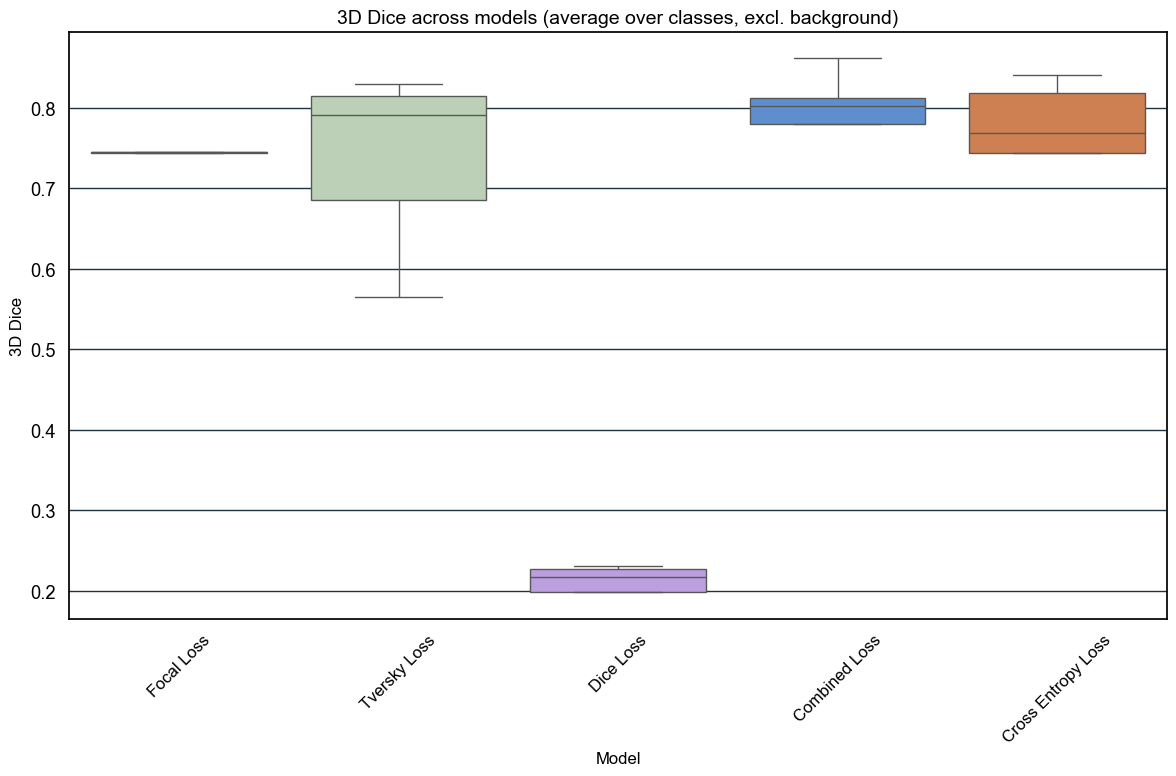

C:\Users\ivvbr\AppData\Local\Temp\ipykernel_26268\4135001608.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


C:\Users\ivvbr\AppData\Local\Temp\ipykernel_26268\4135001608.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


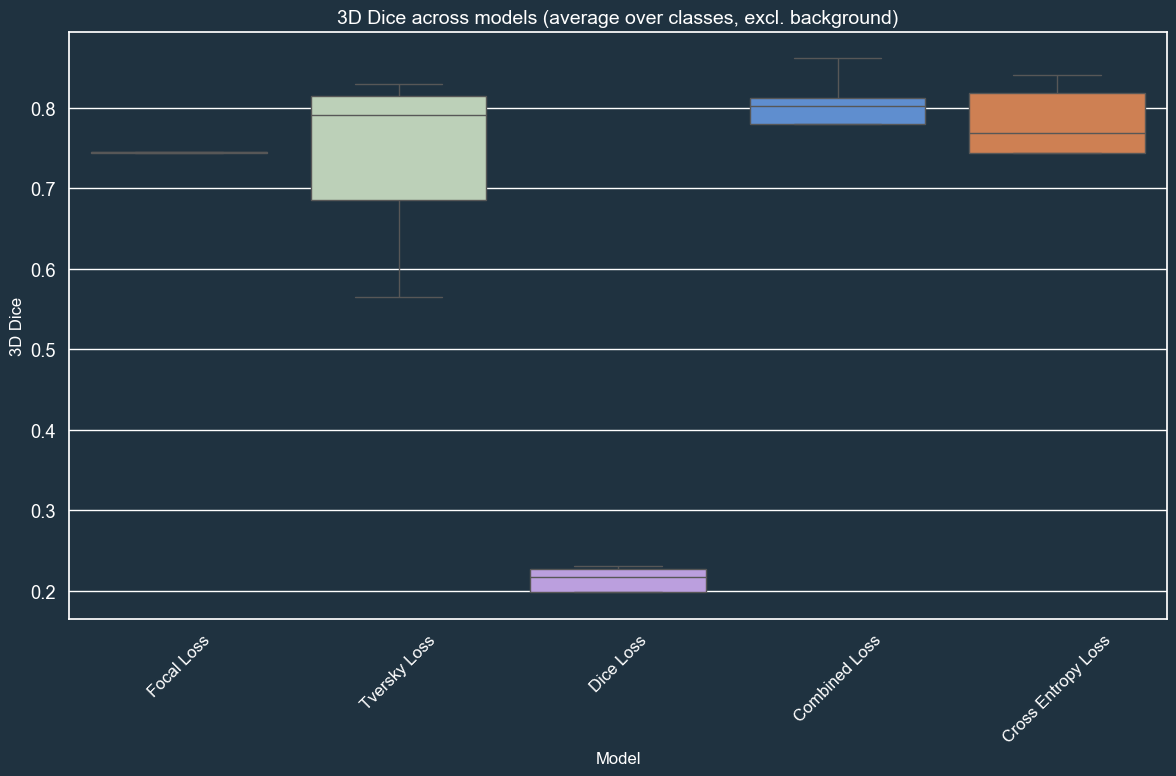

C:\Users\ivvbr\AppData\Local\Temp\ipykernel_26268\4135001608.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


In [26]:
# Prepare data for plotting
all_data = []

for model_name, metrics in metrics_dict.items():
    for metric_name in ['3D Dice', '3D Hausdorff distance']:
        metric_values = np.array(metrics[metric_name])  # Shape: (num_samples, num_classes)
        num_samples, num_classes = metric_values.shape
        # Exclude background class (assume class 0 is background)
        values = metric_values[:, 1:]  # Shape: (num_samples, num_classes -1)
        # Compute the average over classes (axis=1)
        avg_values = np.nanmean(values, axis=1)  # Shape: (num_samples,)
        for value in avg_values:
            all_data.append({
                'Model': model_name,
                'Metric': metric_name,
                'Value': value
            })

df = pd.DataFrame(all_data)

# Create boxplots for each metric using custom themes
for theme in ['light', 'dark']:
    if theme == 'dark':
        set_custom_dark_theme()
    else:
        set_custom_light_theme()
    for metric_name in df['Metric'].unique():
        plt.figure(figsize=(12, 8))
        sns.boxplot(
            data=df[df['Metric'] == metric_name],
            x='Model',
            y='Value',
            palette=model_palette,
            showfliers=False  # Hide outliers for clarity
        )
        plt.title(f"{metric_name} across models (average over classes, excl. background)", fontsize=14)
        plt.ylabel(metric_name, fontsize=12)
        plt.xlabel('Model', fontsize=12)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{metric_name}_average_{theme}.png", dpi=300)
        plt.show()